In [1]:
import pickle
import numpy as np
import torch
import sys

sys.path.insert(0, '/research/iprobe-ashbau12/repos/outside/OpenGait/opengait/')
from utils.evaluation import cuda_dist

In [2]:
test_metric_file = "./all_probe_test_metrics.pkl"
with open(test_metric_file, "rb") as f:
    probe_seqs = pickle.load(f)                                 
    gallery_seqs = pickle.load(f)                               
    seq_type = pickle.load(f)
    acc = pickle.load(f)
    gallery_y = pickle.load(f)
    label = pickle.load(f)
    probe_sequence_label_mask = pickle.load(f)
    gallery_labels = pickle.load(f)
    feature = pickle.load(f)
    to_save = pickle.load(f)

In [ ]:
# subject stuff
num_probe_subjects_with_gallery = len(set(label[probe_sequence_label_mask]))
num_gallery_subjects = len(set(gallery_labels))


print("Num. probe subjects with gallery: {}".format(num_probe_subjects_with_gallery))
print("Num. gallery subjects:            {}".format(num_gallery_subjects))
print(probe_seqs)

In [3]:
gallery_collapsed = []                                                      
label_collapsed = []

for l, g in to_save['gallery'].items():                                     
    label_collapsed.append(l)                                               
    gallery_collapsed.append(np.stack(g).mean(0))                           
label_collapsed = np.array(label_collapsed)                                 
gallery_collapsed = np.stack(gallery_collapsed)                             

gallery_x = gallery_collapsed                                               
gallery_y = label_collapsed   

In [5]:
all_probes = []
num_rank = 10

for (p, probe_seq) in enumerate(probe_seqs):                   
    for gallery_seq in gallery_seqs:                           
        # for (v1, probe_view) in enumerate(view_list):                     
        #     for (v2, gallery_view) in enumerate(view_list):                           
        gseq_mask = np.isin(seq_type, gallery_seq) # & np.isin(             
        #     view, [gallery_view])                                         
        '''                                                                 
        gallery_x = feature[gseq_mask, :]                                   
        gallery_y = label[gseq_mask]                                        
        '''                                                                 

        pseq_mask = np.isin(seq_type, probe_seq)                            
        # pseq_mask = np.isin(seq_type,                                     
        #                     probe_seq) & probe_sequence_label_mask        
        # & np.isin(                                                        
        #     view, [probe_view])                                           
        probe_x = feature[pseq_mask, :]                                     
        probe_y = label[pseq_mask]
        
        all_probes.append(set(probe_y))

        dist = cuda_dist(probe_x, gallery_x, 'cos')                        
        idx = dist.sort(1)[1].cpu().numpy() 
        acc[p, :, :, :] = np.round(np.sum(np.cumsum(np.reshape(probe_y, [-1, 1]) == 
                                                    gallery_y[idx[:, 0:num_rank]],
                                                    1) > 0,
                                          0) * 100 / dist.shape[0],
                                   2)

In [ ]:
print(len(all_probes[0]))

In [6]:
probe_y.shape

(4410,)

In [7]:
probe_y

array(['G00169', 'G00169', 'G00169', ..., 'G00419', 'G00419', 'G00419'],
      dtype='<U6')

In [8]:
np.reshape(probe_y, [-1, 1])

array([['G00169'],
       ['G00169'],
       ['G00169'],
       ...,
       ['G00419'],
       ['G00419'],
       ['G00419']], dtype='<U6')

In [20]:
gallery_y[idx[:, 0:num_rank]]

array([['G00358', 'G00515', 'G00341', ..., 'G00538', 'G00022', 'G00306'],
       ['G00169', 'G00358', 'G00341', ..., 'G00515', 'G00022', 'G00076'],
       ['G00358', 'G00076', 'G00169', ..., 'G00341', 'G00047', 'G00022'],
       ...,
       ['G00419', 'G00449', 'G00329', ..., 'G00534', 'G00257', 'G00550'],
       ['G00419', 'G00449', 'G00412', ..., 'G00257', 'G00534', 'G00060'],
       ['G00419', 'G00449', 'G00412', ..., 'G00550', 'G00003', 'G00257']],
      dtype='<U6')

In [25]:
np.round(np.sum(np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[idx[:, 0:num_rank]], 1) > 0, 0)*100 / dist.shape[0], 2)

array([68.5 , 75.12, 77.28, 78.37, 79.05, 79.61, 80.16, 80.41, 80.66,
       80.84])

In [33]:
(np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[idx[:, 0:num_rank]], 1) > 0).shape

(4410, 10)

In [14]:
gallery_y

array(['G00169', 'G00516', 'G00430', 'G00170', 'G00374', 'G00045',
       'G00038', 'G00246', 'G00341', 'G00496', 'G00048', 'G00304',
       'G00325', 'G00352', 'G00255', 'G00358', 'G00511', 'G00380',
       'G00083', 'G00550', 'G00251', 'G00356', 'G00022', 'G00412',
       'G00515', 'G00300', 'G00393', 'G00270', 'G00534', 'G00179',
       'G00003', 'G00549', 'G00571', 'G00401', 'G00046', 'G00232',
       'G00449', 'G00533', 'G00073', 'G00443', 'G00293', 'G00518',
       'G00060', 'G00017', 'G00264', 'G00219', 'G00452', 'G00247',
       'G00378', 'G00071', 'G00076', 'G00431', 'G00134', 'G00329',
       'G00354', 'G00469', 'G00257', 'G00218', 'G00386', 'G00500',
       'G00538', 'G00072', 'G00448', 'G00545', 'G00306', 'G00295',
       'G00047', 'G00499', 'G00286', 'G00215', 'G00088', 'G00456',
       'G00419'], dtype='<U6')

In [16]:
idx[0, 0:num_rank]

array([15, 24,  8,  0, 65, 39, 58, 60, 22, 64])

In [24]:
dist.shape

torch.Size([4410, 73])

In [26]:
acc.shape

(1, 6840, 6840, 10)

In [29]:
len(gallery_seqs)

1

In [30]:
acc

array([[[[68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         ...,
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84]],

        [[68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         ...,
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84]],

        [[68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         ...,
         [68.5 , 75.12, 77.28, ..., 80.41, 80.66, 80.84],
         [68.5 , 75.12, 77

In [35]:
probe_sequence_label_mask.sum()

6084

In [36]:
pseq_mask.sum()

4410

In [37]:
(probe_sequence_label_mask & pseq_mask).sum()

3654

In [38]:
feature.shape

(6840, 31, 256)

In [155]:
probe_in_top_N = np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[idx[:, 0:num_rank]], 1) > 0
ranked_distances = dist.sort(1)[0][:, 0:num_rank]

mated_probes_mask = np.isin(probe_y, gallery_y)
non_mated_probes_mask = (~mated_probes_mask)
cos_distance_thresholds = np.arange(0, 1, 0.0001)


ranks = np.array([1, 5, 10]) - 1
fnirs = np.zeros((len(ranks), len(cos_distance_thresholds)))
fpirs = np.zeros((len(ranks), len(cos_distance_thresholds)))

for ii, thresh in enumerate(cos_distance_thresholds):
    for jj, rank in enumerate(ranks):
        fnir = np.logical_or(~probe_in_top_N[mated_probes_mask, rank],
                             (ranked_distances[mated_probes_mask, rank].cpu().numpy() > thresh)).sum()
        fpir = np.logical_or(probe_in_top_N[non_mated_probes_mask, rank],
                             (ranked_distances[non_mated_probes_mask, rank].cpu().numpy() < thresh)).sum()
    
    
        fnirs[jj, ii] = fnir
        fpirs[jj, ii] = fpir
    
fnirs = fnirs / mated_probes_mask.sum()
fpirs = fpirs / non_mated_probes_mask.sum()

In [76]:
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline
dpi = 150

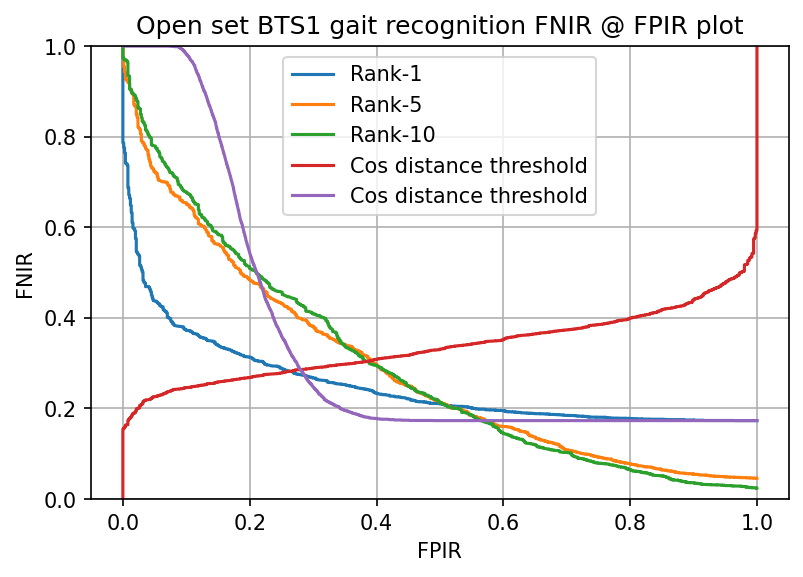

In [161]:
fig = plt.figure(facecolor='white', dpi=dpi)

for rr, rank in enumerate(ranks):
    plt.plot(fpirs[rr, :], fnirs[rr, :], label='Rank-{}'.format(rank+1))
plt.plot(fpirs[0, :], cos_distance_thresholds, label='Cos distance threshold')
plt.plot(cos_distance_thresholds, fnirs[0, :], label='Cos distance threshold')

    
# plt.semilogx(fpirs[0, :], fnirs[0, :], label='Rank-{}'.format(1))
# plt.semilogx(fpirs[1, :], fnirs[1, :], label='Rank-{}'.format(5))
# plt.semilogx(fpirs[2, :], fnirs[2, :], label='Rank-{}'.format(10))

plt.title('Open set BTS1 gait recognition FNIR @ FPIR plot')
plt.xlabel('FPIR')
plt.ylabel('FNIR')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.ylim([0, 1])
plt.show()


In [138]:
np.logical_or(~probe_in_top_N[mated_probes_mask, 0],
              (ranked_distances[mated_probes_mask, 0].cpu().numpy() > thresh)).sum()

3654

In [132]:
thresh

0.0

In [133]:
mated_probes_mask.sum()

3654

In [134]:
fnirs.max()

0.0